In [1]:
import os
os.chdir("/home/ohada/ProjectBDir")

import diffusers
from diffusers import *
import torch
from glob import glob
from diffusers.utils import load_image
from PIL import Image
import unclip
import matplotlib.pyplot as plt
%matplotlib inline

2024-03-19 10:31:49.504645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 10:31:50.153978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ohada/DeepProject/DeepProject/ProjectPath/venv/lib/python3.10/site-packages/diffusers/models/dual_transformer_2d.py:20: FutureWarning: `DualTransformer2DModel` is deprecated and will be removed in version 0.29. Importing `DualTransformer2DModel` from `diffusers.models.dual_transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.transformers.dual_transformer_2d import DualTransformer2DModel`, instead.
  deprecate("DualTransformer2DModel", "0.29", deprecation_message)


In [2]:
import sys
sys.executable

'/home/ohada/DeepProject/DeepProject/ProjectPath/venv/bin/python3'

Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

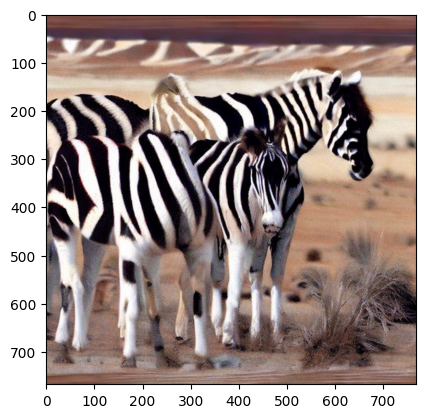

In [6]:
img = unclip.unclip(num_inference_steps=20, guidance_scale=10, noise_level=0)
# Show 'img':
plt.imshow(img)